# Trabajo Práctico 5 - Grupo 2
## Matías Bergerman, Pablo González Leiro, Tobias Demeco, Matías Tripoli

In [2]:
# Import libraries
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import gaussian, convolve2d, fftconvolve
from scipy.interpolate import interp1d
from skimage import color, data, restoration

In [3]:
def display_np(x, scale = 1.0, resampling = Image.Resampling.BICUBIC):
    im = Image.fromarray(x.clip(0, 255).astype(np.uint8))
    display(im.resize((np.array(im.size)*scale).astype(int), resampling))

## Ejercicio 1
### Inverse Filtering

In [4]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

#### Blur

Imagen original:


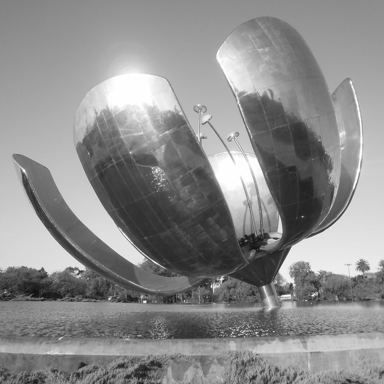

Imagen degradada:


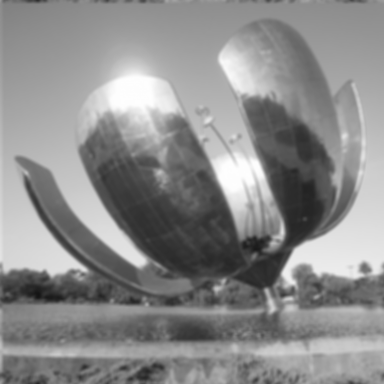

Imagen restaurada:


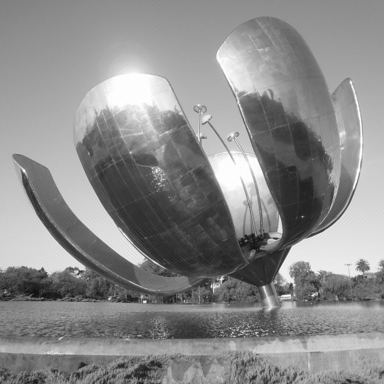

MSE: 18.363017801339666


In [30]:
# Abrir la imagen original
f = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)
F = np.fft.rfft2(f)
print('Imagen original:')
display_np(f, 0.5)

# Obtengo filtro de degradación (Gaussian Blur)
h = gaussian_kernel(10)
H = np.fft.rfft2(gaussian_kernel(10), s=f.shape)

# Degrado la imagen
G = H*F
g = np.fft.irfft2(G)
print('Imagen degradada:')
display_np(g, 0.5)

# Obtengo filtro inverso limitado en ancho de banda
n = 0.001     # con este parámetro busco limitar los ceros del filtro de degradación y limito en banda
H_hat = np.copy(H)
H_hat[np.where(np.abs(H_hat) < n)] = n  # si n es menor el filtro inverso se aproxima mejor al de degradación
R = np.divide(1,H_hat)

# Aplico el filtro inverso
F_hat = R*G
f_hat = np.fft.irfft2(F_hat)
print('Imagen restaurada:')
display_np(f_hat, 0.5)

MSE = np.array(np.abs(f-f_hat)**2).mean()
print('MSE:', MSE)

#### Blur + Noise

Imagen original:


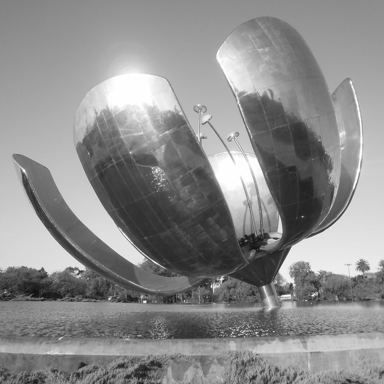

Imagen degradada:


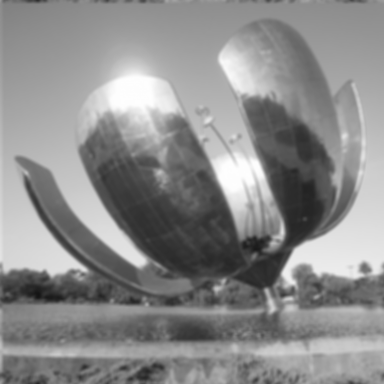

Imagen degradada + ruido blanco:


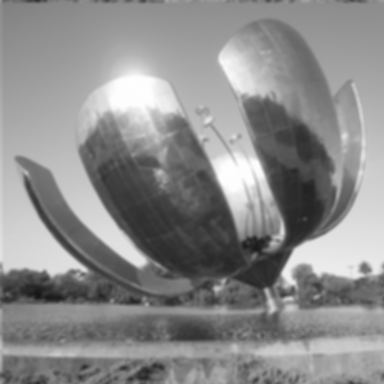

Imagen restaurada:


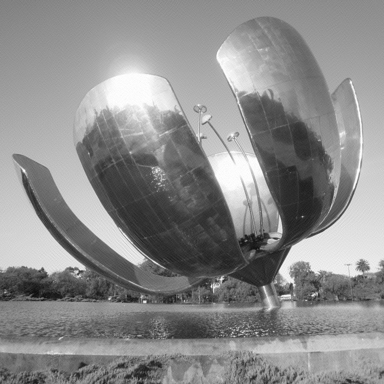

MSE: 58.34945162229557


In [32]:
# Abrir la imagen original
f = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)
F = np.fft.rfft2(f)
print('Imagen original:')
display_np(f, 0.5)

# Obtengo filtro de degradación (Gaussian Blur)
h = gaussian_kernel(10)
H = np.fft.rfft2(gaussian_kernel(10), s=f.shape)

# Degrado la imagen
HF = H*F
hf = np.fft.irfft2(HF)
print('Imagen degradada:')
display_np(hf, 0.5)

# Agrego ruido blanco gaussiano 
g = add_gaussian_noise(hf, sigma=0.01)
G = np.fft.rfft2(g)
print('Imagen degradada + ruido blanco:')
display_np(g, 0.5)

# Obtengo filtro inverso limitado en ancho de banda
n = 0.001     # con este parámetro busco limitar los ceros del filtro de degradación y limito en banda
H_hat = np.copy(H)
H_hat[np.where(np.abs(H_hat) < n)] = n  # ahora si n es muy chico el ruido blanco empieza a dominar ya que R amplifica frecuencias espaciales altas
R = np.divide(1,H_hat)

# Aplico el filtro inverso
F_hat = R*G
f_hat = np.fft.irfft2(F_hat)
print('Imagen restaurada:')
display_np(f_hat, 0.5)

MSE = np.array(np.abs(f-f_hat)**2).mean()
print('MSE:', MSE)

## Ejercicio 2
### Wiener

In [7]:
def blur(img, mode = 'box', kernel_size = 3):
    # mode = 'box' or 'gaussian' or 'motion'
    dummy = np.copy(img)
    if mode == 'box':
        h = np.ones((kernel_size, kernel_size)) / kernel_size ** 2
    elif mode == 'gaussian':
        h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
    elif mode == 'motion':
        h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

Imagen original:


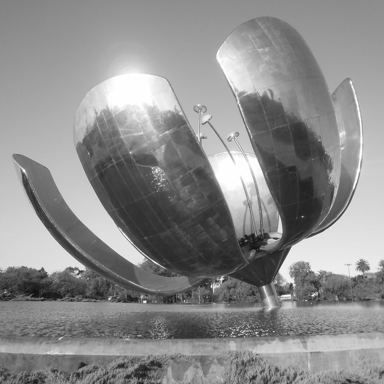

Imagen con blur y noise:


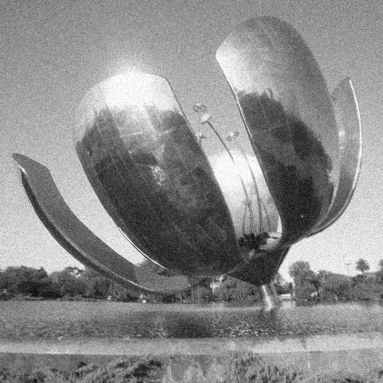

Imagen filtrada:


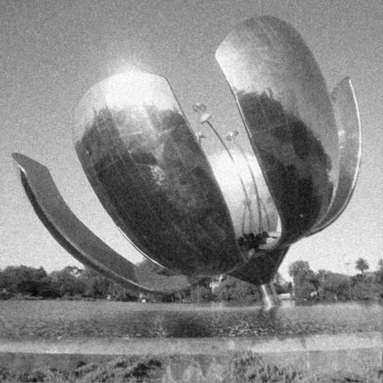

In [8]:
# Abrir la imagen original
img = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)

# Aplicar blur
blurred_img = blur(img, mode = 'motion', kernel_size = 3)

# Agregar ruido gausiano
noisy_img = add_gaussian_noise(blurred_img, sigma = 20)

# Aplicar el filtrado de Wiener
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(noisy_img, kernel, K = 30)

# Re-escalado del resultado
filtered_img = interp1d([filtered_img.min(), filtered_img.max()],[img.min(), img.max()])(filtered_img)

print('Imagen original:')
display_np(img, 0.5)
print('Imagen con blur y noise:')
display_np(noisy_img, 0.5)
print('Imagen filtrada:')
display_np(filtered_img, 0.5)

## Ejercicio 3
### Blind deconvolution

Imagen original:


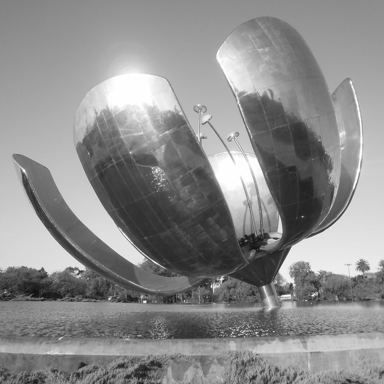

Imagen con blur:


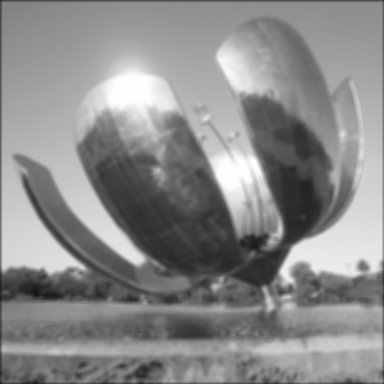

Imagen deconvolucionada:


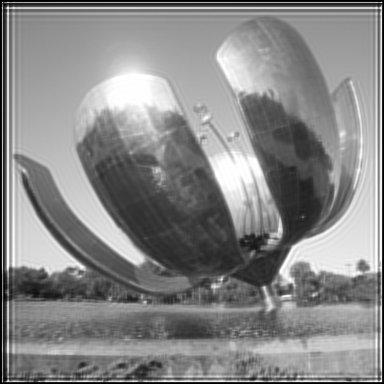

In [9]:
# Source: https://scikit-image.org/docs/dev/auto_examples/filters/plot_deconvolution.html

img = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64)
img /= img.max()

rng = np.random.default_rng()

psf = np.ones((10, 10)) / 10**2
img_blur = convolve2d(img, psf, 'same')

# Restore Image using Richardson-Lucy algorithm
img_deconvolved = restoration.richardson_lucy(img_blur, psf, num_iter=30)

print('Imagen original:')
display_np(img*255, 0.5)
print('Imagen con blur:')
display_np(img_blur*255, 0.5)
print('Imagen deconvolucionada:')
display_np(img_deconvolved*255, 0.5)

## Ejercicio 4
### Motion blur

In [10]:
def motion_blur(img, kernel_size):
    h = np.eye(kernel_size) / kernel_size
    return convolve2d(img, h, mode = 'valid')

Motion blur con un kernel de 10:


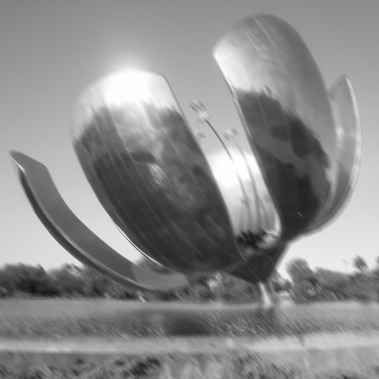

Motion blur con un kernel de 50:


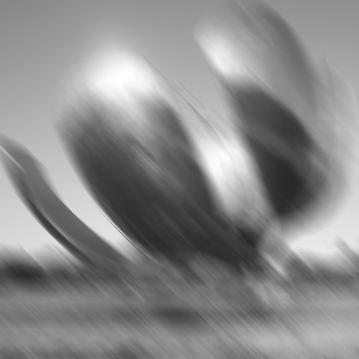

In [11]:
# Abrir la imagen original
img = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)

print('Motion blur con un kernel de 10:')
display_np(motion_blur(img, 10), 0.5)

print('Motion blur con un kernel de 50:')
display_np(motion_blur(img, 50), 0.5)

## Ejercicio 5
### Regularizacion y metodos iterativos

Imagen original:


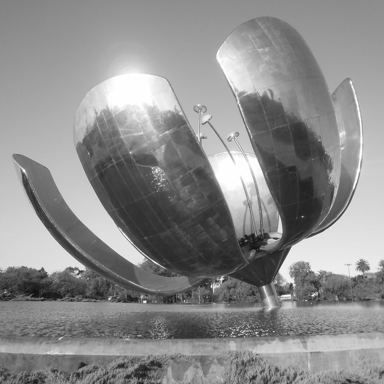

Imagen degradada:


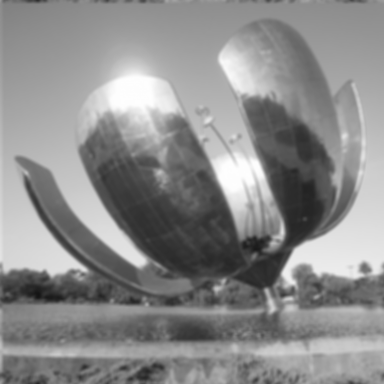

Imagen degradada con ruido blanco:


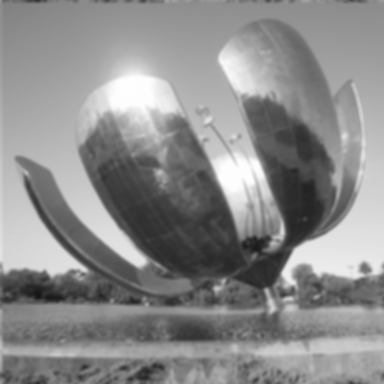

In [194]:
# Abrir la imagen original
f = cv2.imread('images/floralis_generica.jpg', cv2.IMREAD_GRAYSCALE)
F = np.fft.rfft2(f)
print('Imagen original:')
display_np(f, 0.5)

# Obtengo filtro de degradación (Gaussian Blur)
h = gaussian_kernel(10)
H = np.fft.rfft2(gaussian_kernel(10), s=f.shape)

# Degrado la imagen
HF = H*F
hf = np.fft.irfft2(HF)
print('Imagen degradada:')
display_np(hf, 0.5)

# Agrego ruido blanco gaussiano 
g = add_gaussian_noise(hf, sigma=0.01)
G = np.fft.rfft2(g)
print('Imagen degradada con ruido blanco:')
display_np(g, 0.5)

#### Regularización directa

Imagen restaurada:


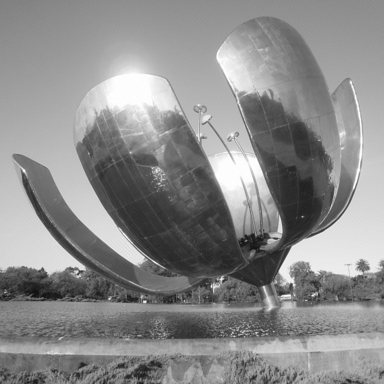

MSE: 17.492109676569275


In [220]:
# Realizo regularización de Tikhinov-Miller usando el Laplaciano
gamma = 1e-7      # coeficiente de regularización (si es 0 tengo el filtro inverso)
p = [[0,1,0],[1,-4,1],[0,1,0]]      # Kernell Laplaciano
P = np.fft.rfft2(p, s=f.shape)
R = H.conj() / (np.abs(H)**2+gamma*np.abs(P)**2)     # Solución de regularización de Tikhinov-Miller

# Aplico el filtro obtenido
F_hat = R*G
f_hat = np.fft.irfft2(F_hat)
print('Imagen restaurada:')
display_np(f_hat, 0.5)

MSE = np.array(np.abs(f-f_hat)**2).mean()
print('MSE:', MSE)

Para encontrar el valor óptimo de $\gamma$ hay muchos algoritmos. Uno sencillo sería una busqueda binaria en un cierto rango de valores en función del MSE.

#### Regularización iterativa

Imagen restaurada:


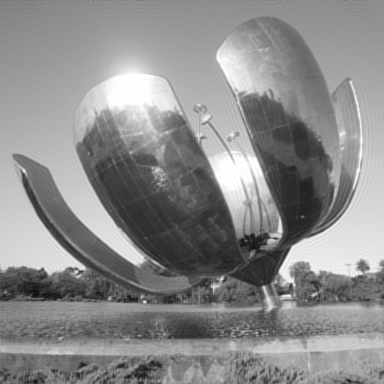

MSE: 73.03229085116897


In [260]:
F_hat = np.empty_like(F)
beta = 2/((np.abs(H)**2).max()+0.1)     # |1 - beta*|H|^2)| < 1
N = 256
H_conj = H.conj()
for i in range(N):
    F_hat = F_hat + beta*H_conj*(G - H*F_hat)

f_hat = np.fft.irfft2(F_hat)
print('Imagen restaurada:')
display_np(f_hat, 0.5)

MSE = np.array(np.abs(f-f_hat)**2).mean()
print('MSE:', MSE)

#### Regularización iterativa (fórmula cerrada)

Imagen restaurada:


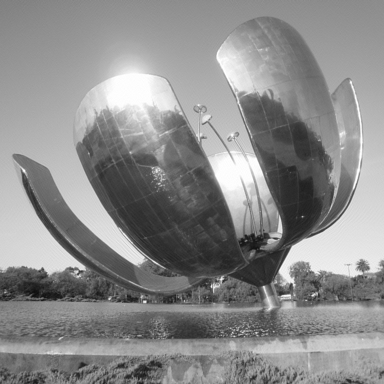

MSE: 19.844553076761812


In [258]:
F_hat = np.empty_like(F)
beta = 2/((np.abs(H)**2).max()+0.1)     # |1 - beta*|H|^2)| < 1
N = 2**18

# Obtengo filtro de degradación limitado en ancho de banda
n = 1e-24     # con este parámetro busco limitar los ceros del filtro de degradación y limito en banda
H_hat = np.copy(H)
H_hat[np.where(np.abs(H_hat) < n)] = n  # si n es menor el filtro inverso se aproxima mejor al de degradación

F_hat = np.divide(1-(1-beta*np.abs(H_hat)**2)**N,H_hat)*G

f_hat = np.fft.irfft2(F_hat)
print('Imagen restaurada:')
display_np(f_hat, 0.5)

MSE = np.array(np.abs(f-f_hat)**2).mean()
print('MSE:', MSE)

## Ejercicio 6
### Eliminación de interferencia

In [14]:
from PIL import Image
from scipy.fft import fft2, fftshift, ifftshift, ifft2
from matplotlib import pyplot as plt
import numpy as np

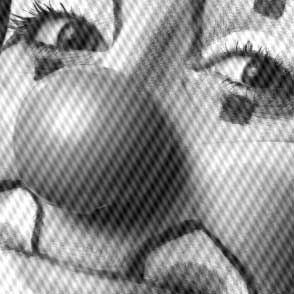

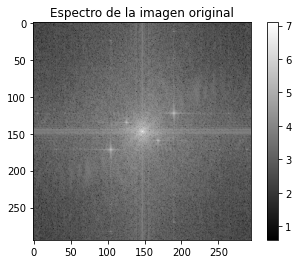

In [15]:
clown = Image.open("images/clown.jpg")
clown_arr = np.asarray(clown)[:,:,0]
clown_freq = fftshift(fft2(clown_arr))

display(clown)
# Plot spectrum
clown_freq_log = np.log10(np.abs(clown_freq)+1)
plt.imshow(clown_freq_log, cmap="gray", vmin=np.min(clown_freq_log), vmax=np.max(clown_freq_log))
plt.title("Espectro de la imagen original")
plt.colorbar()


C:\Users\Matias\AppData\Local\Temp/ipykernel_18380/1759541243.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  H[u, v] = ( 1 / (1 + (D0k/Dkplus)**n ) ) * ( 1 / (1 + (D0k/Dkminus)**n ) )


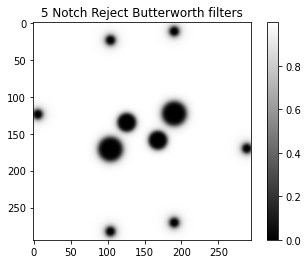

In [16]:
# Butterworth Notch filter
import numpy as np
from matplotlib import pyplot as plt

def Dk(u:int, v:int, M:int, N:int, uk:int, vk:int) -> float:
    return np.sqrt( (u-M//2-uk)**2  + (v-N//2-vk)**2 )

def notchR2d(D0k, n, M, N, uk, vk):
    H = np.zeros((M,N))
    for u in range(M):
        for v in range(N):
            Dkplus = Dk(u, v, M, N, uk, vk)
            Dkminus = Dk(u, v, M, N, -uk, -vk)
            H[u, v] = ( 1 / (1 + (D0k/Dkplus)**n ) ) * ( 1 / (1 + (D0k/Dkminus)**n ) )
    return H

M = N = 294
Hnotch1 = notchR2d(D0k=17, n=8, M=M, N=N, uk=24, vk=-43)
Hnotch2 = notchR2d(D0k=13, n=8, M=M, N=N, uk=12, vk=21)
Hnotch3 = notchR2d(D0k=7, n=4, M=M, N=N, uk=123, vk=43)
Hnotch4 = notchR2d(D0k=7, n=4, M=M, N=N, uk=23, vk=141)
Hnotch5 = notchR2d(D0k=7, n=4, M=M, N=N, uk=135, vk=-43)
Hnotch = Hnotch1 * Hnotch2 * Hnotch3 * Hnotch4 * Hnotch5

plt.imshow(Hnotch, cmap="gray")
plt.title("5 Notch Reject Butterworth filters")
plt.colorbar()
plt.show()

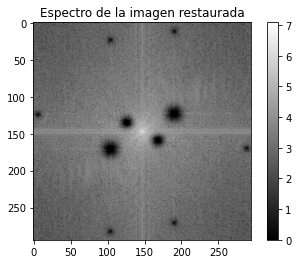

In [17]:
clown_freq_filtered = np.multiply(clown_freq, Hnotch)

# Plot spectrum of filtered image
clown_freq_filtered_log = np.log10(np.abs(clown_freq_filtered) + 1)
plt.imshow(clown_freq_filtered_log, cmap="gray")
plt.title("Espectro de la imagen restaurada")
plt.colorbar()


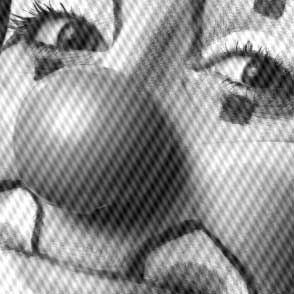

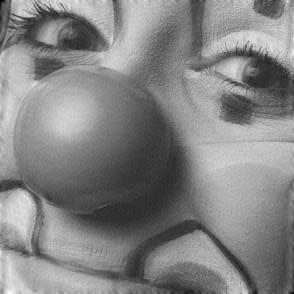

In [18]:
clown_filtered = np.real(ifft2(ifftshift(clown_freq_filtered)))
plt.imsave("images/clown_filtered.jpg", clown_filtered, format="jpg", cmap="gray")

# Plot original image vs. filtered image
display(clown, Image.open("images/clown_filtered.jpg"))


In [19]:
# # Butterworth Band Reject filter
# import numpy as np
# from matplotlib import pyplot as plt

# def D(u:int, v:int, M:int, N:int) -> float:
#     return np.sqrt( (u-M//2)**2  + (v-N//2)**2 )

# def butterBR2d(C0, W, n, M, N):
#     H = np.zeros((M,N))
#     for u in range(M):
#         for v in range(N):
#             Duv = D(u, v, M, N)
#             H[u, v] = 1 / (1 + ( (Duv*W) / (Duv**2 - C0**2) )**(2*n) )
#     return H

# M = N = 294
# H2 = butterBR2d(C0=64, W=16, n=2, M=M, N=N)

# plt.imshow(H2, cmap="gray")
# plt.title("Band Reject 2D Butterworth filter of 2th order")
# plt.colorbar()
# plt.show()

# plt.plot(H2[:,N//2])
# plt.title("Band Reject Butterworth filter")
# plt.legend(["n=2"])
# #plt.hlines(y=[gammaL, gammaH], xmin=0, xmax=M, colors="k" ,linestyles="dotted")
# plt.show()
